In [ ]:
import torch
from torchvision import models, transforms
from PIL import Image

#loading the model and preprocesing image
model = models.resnet50(weights='IMAGENET1K_V1')
model.eval()

preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

img = Image.open("test_data\monkey_test.jpg")
input_tensor = preprocess(img).unsqueeze(0) 

with torch.no_grad():
    output = model(input_tensor)

target_class = output.argmax(dim=1).item()

print(f"Model predicts class index: {target_class}")

Model predicts class index: 373


In [25]:
import torch

def IDG(inputs, model, target_class, pcsteps=50, baseline=None, steps=50):
    if baseline is None:
        baseline = torch.zeros_like(inputs)

    delta = inputs - baseline
    samples = [0]

    with torch.no_grad():
        output_final = model(inputs)
        score_final = output_final[:, target_class]
        output_base = model(baseline)
        score_base = output_base[:, target_class]
        delta_score = score_final - score_base

        #precharacterization algorithm
        for i in range(pcsteps):
            xi = baseline + (i / pcsteps) * delta
            xip1 = baseline + ((i + 1) / pcsteps) * delta

            xi_score = model(xi)[:, target_class]
            xip1_score = model(xip1)[:, target_class]

            step_share = round(((xip1_score - xi_score) / delta_score).item() * steps)
            samples.append(int(step_share))

    # idg calculation
    total_idg = torch.zeros_like(inputs)
    actual_steps = 0

    for i in range(len(samples)):
        if samples[i] <= 0:
            continue

        for j in range(samples[i]):
            alpha = (i / pcsteps) + (j / (pcsteps * samples[i]))

            interp_image = (baseline + alpha * delta).detach().requires_grad_(True)

            out = model(interp_image)
            score = out[:, target_class]

            model.zero_grad()
            score.backward()
            grad_x = interp_image.grad

            #importance factor calculation
            importance_factor = torch.sum(grad_x * delta)

            normalization = pcsteps * samples[i]
            total_idg += (grad_x * importance_factor) / normalization
            actual_steps += 1

    return delta * (total_idg / actual_steps if actual_steps > 0 else total_idg)

In [26]:
attribution = IDG(input_tensor, model, target_class)

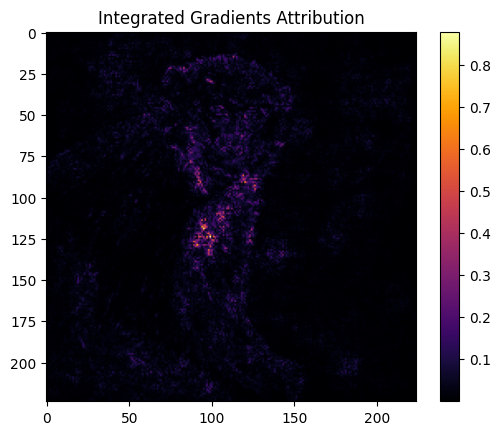

In [27]:
import matplotlib.pyplot as plt
def visualize_attribution(attribution_tensor):

    # sum attribution tensor for visualizaiton
    heatmap = attribution_tensor.squeeze(0).abs().sum(dim=0).cpu().detach().numpy()

    plt.imshow(heatmap, cmap='inferno')
    plt.colorbar()
    plt.title("Integrated Gradients Attribution")
    plt.show()

visualize_attribution(attribution)

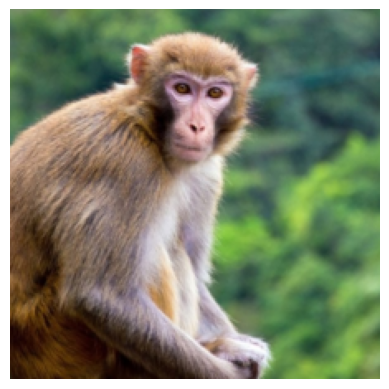

In [ ]:
##VISUALIZATION CODE WRITTEN BY AI

def show_tensor_image(tensor):
    # 1. Remove the batch dimension [1, 3, 224, 224] -> [3, 224, 224]
    img = tensor.squeeze(0)

    # 2. Swap dimensions: [3, 224, 224] -> [224, 224, 3]
    img = img.permute(1, 2, 0)

    # 3. Undo normalization (Approximate values for ImageNet)
    mean = torch.tensor([0.485, 0.456, 0.406])
    std = torch.tensor([0.229, 0.224, 0.225])
    img = img * std + mean

    # 4. Clip to make sure values are between 0 and 1
    img = torch.clamp(img, 0, 1)

    plt.imshow(img.detach().numpy())
    plt.axis('off')
    plt.show()

show_tensor_image(input_tensor)